In [1]:
%matplotlib inline
import numpy as np
import torch
import torch.optim as optim

torch.set_printoptions(edgeitems=2, linewidth=75)

In [2]:
t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c).unsqueeze(1) # <1>
t_u = torch.tensor(t_u).unsqueeze(1) # <1>

t_u.shape

torch.Size([11, 1])

In [3]:
n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

train_indices, val_indices

(tensor([5, 3, 9, 7, 8, 2, 0, 1, 4]), tensor([10,  6]))

In [4]:
t_u_train = t_u[train_indices]
t_c_train = t_c[train_indices]

t_u_val = t_u[val_indices]
t_c_val = t_c[val_indices]

t_un_train = 0.1 * t_u_train
t_un_val = 0.1 * t_u_val

In [5]:
import torch.nn as nn

linear_model = nn.Linear(1, 1) # <1>
linear_model(t_un_val)

tensor([[-1.2253],
        [-0.3583]], grad_fn=<AddmmBackward0>)

In [6]:
linear_model.weight

Parameter containing:
tensor([[-0.2513]], requires_grad=True)

In [7]:
linear_model.bias

Parameter containing:
tensor([0.4936], requires_grad=True)

In [8]:
x = torch.ones(1)
linear_model(x)

tensor([0.2423], grad_fn=<ViewBackward0>)

In [9]:
x = torch.ones(10, 1)
linear_model(x)

tensor([[0.2423],
        [0.2423],
        [0.2423],
        [0.2423],
        [0.2423],
        [0.2423],
        [0.2423],
        [0.2423],
        [0.2423],
        [0.2423]], grad_fn=<AddmmBackward0>)

In [10]:
linear_model = nn.Linear(1, 1) # <1>
optimizer = optim.SGD(
    linear_model.parameters(), # <2>
    lr=1e-2)

In [11]:
linear_model.parameters()

<generator object Module.parameters at 0x736c3b12e260>

In [12]:
list(linear_model.parameters())

[Parameter containing:
 tensor([[-0.9885]], requires_grad=True),
 Parameter containing:
 tensor([-0.4461], requires_grad=True)]

In [13]:
def training_loop(n_epochs, optimizer, model, loss_fn, t_u_train, t_u_val,
                  t_c_train, t_c_val):
    for epoch in range(1, n_epochs + 1):
        t_p_train = model(t_u_train) # <1>
        loss_train = loss_fn(t_p_train, t_c_train)

        t_p_val = model(t_u_val) # <1>
        loss_val = loss_fn(t_p_val, t_c_val)
        
        optimizer.zero_grad()
        loss_train.backward() # <2>
        optimizer.step()

        if epoch == 1 or epoch % 1000 == 0:
            print(f"Epoch {epoch}, Training loss {loss_train.item():.4f},"
                  f" Validation loss {loss_val.item():.4f}")


In [14]:
def loss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c)**2
    return squared_diffs.mean()

linear_model = nn.Linear(1, 1) # <1>
optimizer = optim.SGD(linear_model.parameters(), lr=1e-2)

training_loop(
    n_epochs = 3000, 
    optimizer = optimizer,
    model = linear_model,
    loss_fn = loss_fn,
    t_u_train = t_un_train,
    t_u_val = t_un_val, 
    t_c_train = t_c_train,
    t_c_val = t_c_val)

print()
print(linear_model.weight)
print(linear_model.bias)

Epoch 1, Training loss 82.5497, Validation loss 109.3045
Epoch 1000, Training loss 3.6253, Validation loss 4.2286
Epoch 2000, Training loss 2.6655, Validation loss 4.8611
Epoch 3000, Training loss 2.6292, Validation loss 5.1663

Parameter containing:
tensor([[5.3979]], requires_grad=True)
Parameter containing:
tensor([-17.8617], requires_grad=True)


In [15]:
linear_model = nn.Linear(1, 1)
optimizer = optim.SGD(linear_model.parameters(), lr=1e-2)

training_loop(
    n_epochs = 3000, 
    optimizer = optimizer,
    model = linear_model,
    loss_fn = nn.MSELoss(), # <1>
    t_u_train = t_un_train,
    t_u_val = t_un_val, 
    t_c_train = t_c_train,
    t_c_val = t_c_val)

print()
print(linear_model.weight)
print(linear_model.bias)

Epoch 1, Training loss 191.5774, Validation loss 239.2147
Epoch 1000, Training loss 3.8054, Validation loss 4.2539
Epoch 2000, Training loss 2.6724, Validation loss 4.8319
Epoch 3000, Training loss 2.6295, Validation loss 5.1593

Parameter containing:
tensor([[5.3959]], requires_grad=True)
Parameter containing:
tensor([-17.8505], requires_grad=True)


In [16]:
seq_model = nn.Sequential(
            nn.Linear(1, 13), # <1>
            nn.Tanh(),
            nn.Linear(13, 1)) # <2>
seq_model

Sequential(
  (0): Linear(in_features=1, out_features=13, bias=True)
  (1): Tanh()
  (2): Linear(in_features=13, out_features=1, bias=True)
)

In [17]:
[param.shape for param in seq_model.parameters()]

[torch.Size([13, 1]), torch.Size([13]), torch.Size([1, 13]), torch.Size([1])]

In [18]:
for name, param in seq_model.named_parameters():
    print(name, param.shape)

0.weight torch.Size([13, 1])
0.bias torch.Size([13])
2.weight torch.Size([1, 13])
2.bias torch.Size([1])


In [19]:
from collections import OrderedDict

seq_model = nn.Sequential(OrderedDict([
    ('hidden_linear', nn.Linear(1, 8)),
    ('hidden_activation', nn.Tanh()),
    ('output_linear', nn.Linear(8, 1))
]))

seq_model

Sequential(
  (hidden_linear): Linear(in_features=1, out_features=8, bias=True)
  (hidden_activation): Tanh()
  (output_linear): Linear(in_features=8, out_features=1, bias=True)
)

In [20]:
for name, param in seq_model.named_parameters():
    print(name, param.shape)

hidden_linear.weight torch.Size([8, 1])
hidden_linear.bias torch.Size([8])
output_linear.weight torch.Size([1, 8])
output_linear.bias torch.Size([1])


In [21]:
seq_model.output_linear.bias

Parameter containing:
tensor([0.1672], requires_grad=True)

In [22]:
optimizer = optim.SGD(seq_model.parameters(), lr=1e-3) # <1>

training_loop(
    n_epochs = 5000, 
    optimizer = optimizer,
    model = seq_model,
    loss_fn = nn.MSELoss(),
    t_u_train = t_un_train,
    t_u_val = t_un_val, 
    t_c_train = t_c_train,
    t_c_val = t_c_val)
    
print('output', seq_model(t_un_val))
print('answer', t_c_val)
print('hidden', seq_model.hidden_linear.weight.grad)

Epoch 1, Training loss 175.5813, Validation loss 221.1540
Epoch 1000, Training loss 5.1443, Validation loss 7.7415
Epoch 2000, Training loss 3.6938, Validation loss 8.4409
Epoch 3000, Training loss 1.8608, Validation loss 5.2643
Epoch 4000, Training loss 1.5991, Validation loss 4.8745
Epoch 5000, Training loss 1.5519, Validation loss 5.0918
output tensor([[20.6524],
        [-0.1722]], grad_fn=<AddmmBackward0>)
answer tensor([[21.],
        [ 3.]])
hidden tensor([[ 0.0005],
        [ 0.0025],
        [ 0.0167],
        [ 0.0104],
        [-0.0004],
        [-0.0215],
        [-0.0115],
        [ 0.0199]])


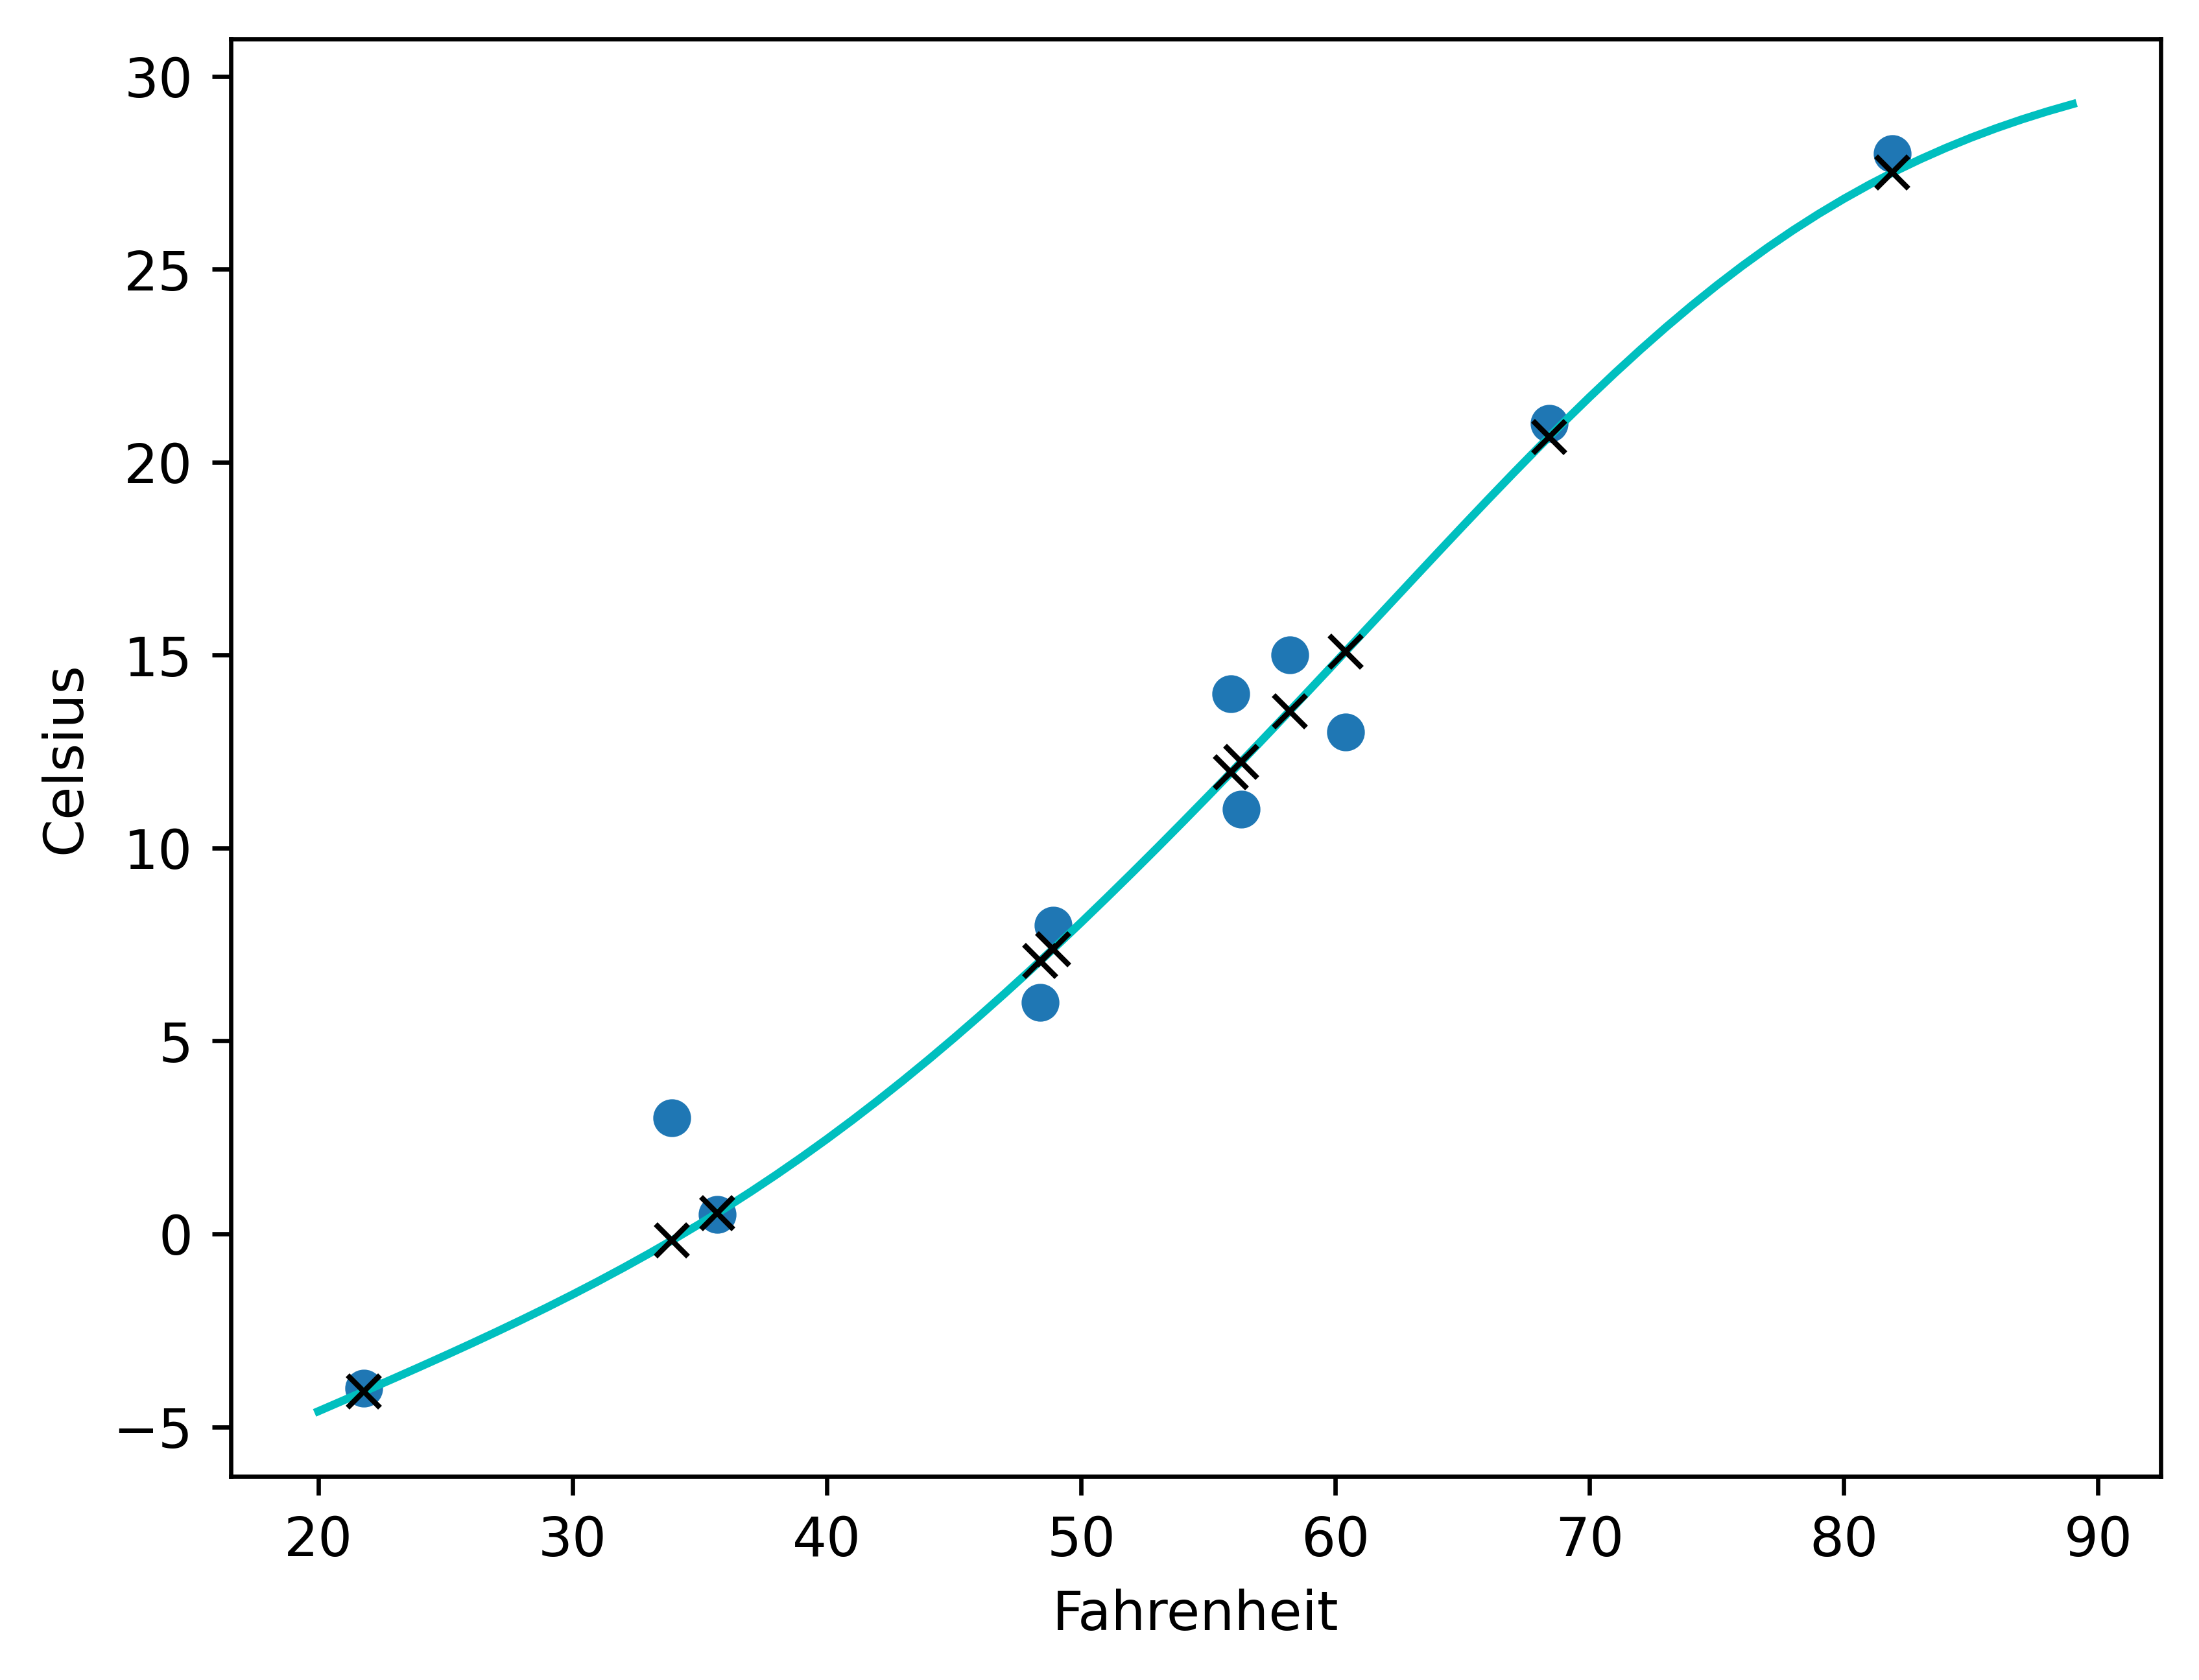

In [23]:
from matplotlib import pyplot as plt

t_range = torch.arange(20., 90.).unsqueeze(1)

fig = plt.figure(dpi=600)
plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.plot(t_range.numpy(), seq_model(0.1 * t_range).detach().numpy(), 'c-')
plt.plot(t_u.numpy(), seq_model(0.1 * t_u).detach().numpy(), 'kx')


Epoch 1, Training loss 180.2658, Validation loss 226.2511
Epoch 1000, Training loss 54.6977, Validation loss 61.7413
Epoch 2000, Training loss 39.1607, Validation loss 41.0927
Epoch 3000, Training loss 25.7517, Validation loss 24.8350
Epoch 4000, Training loss 16.3184, Validation loss 14.4579
Epoch 5000, Training loss 10.1743, Validation loss 8.9869


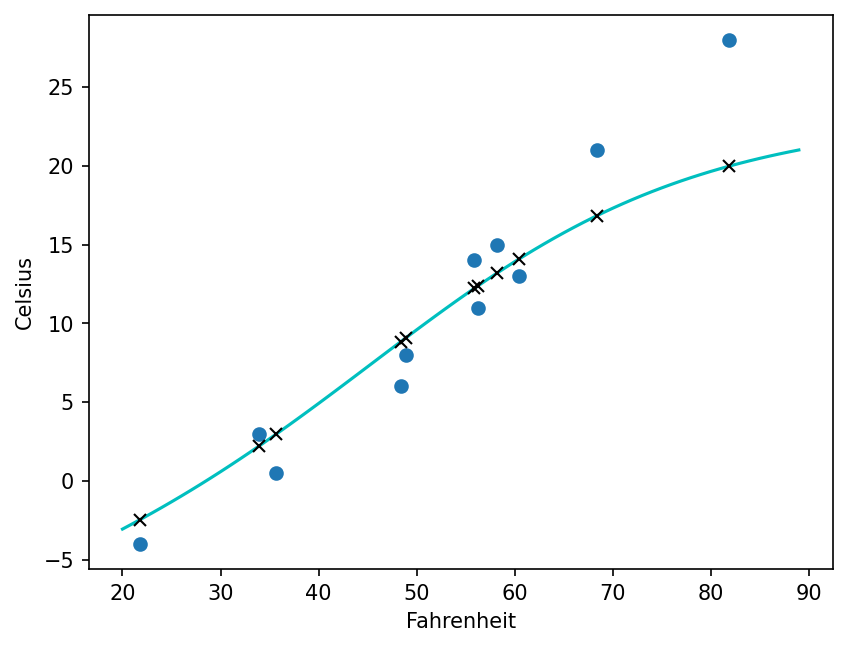

In [24]:
# Exercises here!

neuron_count = 20

seq_model = nn.Sequential(OrderedDict([
    ('hidden_linear', nn.Linear(1, neuron_count)),
    ('hidden_activation', nn.Tanh()),
    ('output_linear', nn.Linear(neuron_count, 1))
]))

optimizer = optim.SGD(seq_model.parameters(), lr=1e-4)

training_loop(
    n_epochs = 5000, 
    optimizer = optimizer,
    model = seq_model,
    loss_fn = nn.MSELoss(),
    t_u_train = t_un_train,
    t_u_val = t_un_val, 
    t_c_train = t_c_train,
    t_c_val = t_c_val)

from matplotlib import pyplot as plt

t_range = torch.arange(20., 90.).unsqueeze(1)

fig = plt.figure(dpi=150)
plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.plot(t_range.numpy(), seq_model(0.1 * t_range).detach().numpy(), 'c-')
plt.plot(t_u.numpy(), seq_model(0.1 * t_u).detach().numpy(), 'kx')
